Подключаем необходимые библиотеки

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro
from scipy.stats import levene
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.power import TTestIndPower
from scipy.stats import bartlett
from scipy.stats import kstest

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Загрузка данных

Получаем данные из файлов: данные по бакетам и по пользователям, и смотрим на них

In [ ]:
abt_by_bucket = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hw_abt_2_bybucket.csv', sep = '\t', index_col=0)
abt_by_user = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hw_abt_2_byuser.csv', sep = '\t', index_col=0)

In [ ]:
abt_by_bucket.head()

,metric_value,users,visits,churn_users,churn_visits
group_id,,,,,
1,1875345.0,155,1419,151,2207
2,1662237.0,138,1320,127,1853
3,1784372.0,128,1281,159,2032
4,1876826.0,163,1644,168,2172
5,1913180.0,156,1675,174,2273


In [ ]:
abt_by_user.head()

,group_id,metric_value,users,visits,churn_users,churn_visits,group
0,8,6630.000,0,0,0,8,A
1,13,6933.976,0,0,1,6,B
2,10,8261.976,1,10,1,8,B
3,4,5522.000,1,9,1,7,A
4,16,5075.976,1,6,0,8,B


В данных есть противоречивые метрики, в которых сумма целевых действий имеет какое-то значение при нуле целевых сессий и пользователей, совершивших данные действия

In [ ]:
abt_by_user[abt_by_user['visits']==0]

,group_id,metric_value,users,visits,churn_users,churn_visits,group
0,8,6630.000,0,0,0,8,A
1,13,6933.976,0,0,1,6,B
5,2,8539.000,0,0,0,8,A
6,8,5714.000,0,0,0,7,A
7,3,7330.000,0,0,0,6,A
...,...,...,...,...,...,...,...
4993,13,6279.976,0,0,0,8,B
4996,12,6464.976,0,0,1,8,B
4997,1,4335.000,0,0,0,8,A
4998,13,6307.976,0,0,1,8,B


Видим, что таких значений достаточно много, что в общем заставляет сомневаться в достоверности данных <br>
В реальной практике было бы необходимо узнать, что именно стало причиной таких значений, однако сейчас просто отфильтруем данные и оставим только те, которые удовлетворяют логике проведения эксперимента, приняв все остальные за недостоверные

In [ ]:
abt_by_user = abt_by_user[abt_by_user['visits']!=0]
abt_by_user.shape

(2242, 7)

In [ ]:
abt_by_user[abt_by_user['group']=='B'].shape

(1150, 7)

Видим, что группы получились с практически одинаковым количеством значений, теперь посмотрим, что они из себя представляют, и правильным ли решением было исключить остальные данные

Выделяем отдельно данные по группе А и по группе B <br>
Затем выделяем данные столбца metric_value для дальнейшего исследования на нормальность и дисперсию <br>
Также сразу смотрим на гистограммы полученных выборок

In [ ]:
A_distr = abt_by_user[abt_by_user.group=='A']
B_distr = abt_by_user[abt_by_user.group=='B']

## Анализ метрики metric_value

In [ ]:
A_distr_metric = A_distr.metric_value
B_distr_metric = B_distr.metric_value

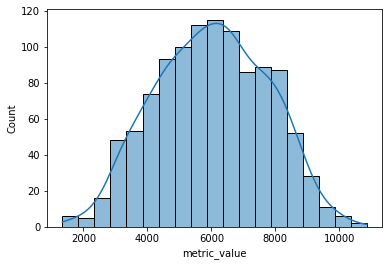

In [ ]:
sns.histplot(data=A_distr_metric, kde=True)

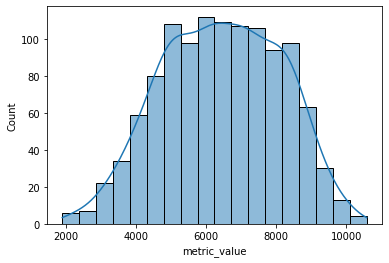

In [ ]:
sns.histplot(data=B_distr_metric, kde=True)

Посмотрев на распределения групп до фильтрации и после, было выявлено, что вид распределений, их средние и 
отклонения сохраняются, значит оставим только более достоверные значения в выборках

## Проверка на нормальность

Проверям выборки на нормальность при помощи Критерия Шапиро-Уилка, т.к. он обладает большей мощностью. Однако проверим также с помощью критерия Колмогорова, так как он более пригоден для больших выборок

In [ ]:
alpha = 0.05
sh_a = shapiro(A_distr_metric)
sh_b = shapiro(B_distr_metric)

print('Распределение A {}нормальное\n'.format( {True:'не ',False:''}[sh_a[1] < alpha]))
print('Распределение B {}нормальное\n'.format( {True:'не ',False:''}[sh_b[1] < alpha]))

Распределение A не нормальное

Распределение B не нормальное



In [ ]:
ks_a = kstest(A_distr_metric, 'norm')
ks_b = kstest(B_distr_metric, 'norm')

print('Распределение {}нормальное\n'.format( {True:'не ',False:''}[ks_a[1] < alpha]))
print('Распределение {}нормальное\n'.format( {True:'не ',False:''}[ks_b[1] < alpha]))

Распределение не нормальное

Распределение не нормальное



Критерии отвергли гипотезу о нормальном распределении величин, однако видя на гистограммах распределения, похожие на нормальные, проверяем это с помощью qq-плота и оцениваем, насколько наши распределения отличаются от нормального

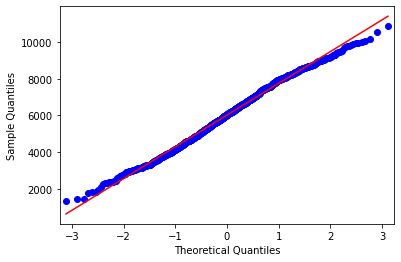

In [ ]:
fig = sm.qqplot(A_distr_metric, line = 's')
plt.show()

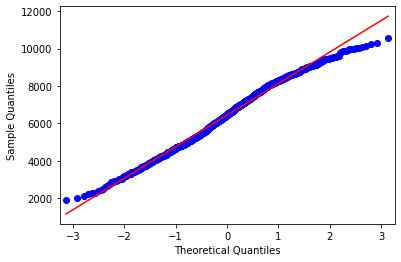

In [ ]:
fig = sm.qqplot(B_distr_metric, line = 's')
plt.show()

Видим, что наши распределения по сравнению с нормальным имеют более длинные хвосты, что также можно было видеть на гистограммах выше, так как даже самые крайние значения встречаются достаточно часто <br> 
Это, видимо, и повлияло на отвержение гипотезы о нормальности

## Проверка равенства дисперсий

Используем критерий Левена, т.к. получили, что распределения не нормальные

In [ ]:
def levene_test(df1, df2, p_value = alpha):
    st = levene(df1, df2)
    print('Дисперсии распределений {}равны\n'.format( {True:'не ', False:''}[st[1] < p_value]))
    print('p-value: {}, alpha: {}'.format(st[1], alpha))

In [ ]:
levene_test(A_distr_metric,B_distr_metric)

Дисперсии распределений равны

p-value: 0.6539246618169864, alpha: 0.05


## Оценка стат. значимости

Оценим статистическую значимость различий исследуемых метрик в
выборках с помощью двухвыборочного критерия Стьюдента, т.к. нам неизвестна дисперсия генеральной совокупности, и выборки независимы, т.к. в каждой группе учавствуют разные пользователи

In [ ]:
ttest = ttest_ind(A_distr_metric, B_distr_metric)
print('Различия {}существенны\n'.format( {False:'не ', True:''}[ttest[1] < alpha])) 
print('p-value: {}, alpha: {}'.format(ttest[1], alpha))

Различия существенны

p-value: 4.1150224946047315e-09, alpha: 0.05


Видим, что различия существенны, нарисуем распределение плотностей выборок и boxplot

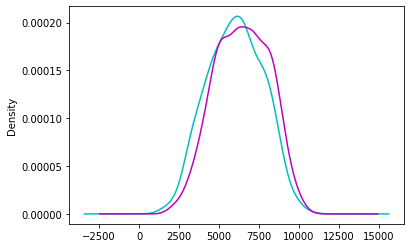

In [ ]:
A_distr_metric.plot.kde(color='c')
B_distr_metric.plot.kde(color='m')

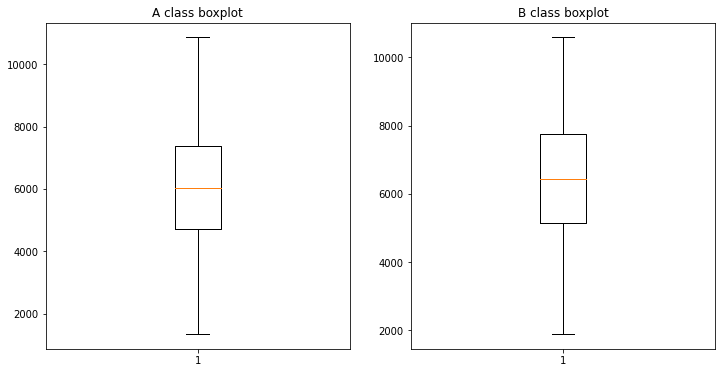

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.boxplot(A_distr_metric)
plt.title('A class boxplot')
plt.subplot(1, 2, 2)
plt.boxplot(B_distr_metric)
plt.title('B class boxplot')
plt.show()

Из графиков видим, что большие значения имеет класс B, и при этом имея значимые различия с классом А, именно его следует рассматривать для внедрения

Также проверим, насколько большой положительный эффект стоит ожидать от внедрения новой технологии при помощи бутстрапированных выборок и доверительного интервала разниц средних значений в этих выборках

In [ ]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [ ]:
A_median_scores = list(map(np.mean, get_bootstrap_samples(np.array(A_distr_metric) , 500)))
B_median_scores = list(map(np.mean, get_bootstrap_samples(np.array(B_distr_metric), 500)))
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(A_median_scores, B_median_scores)))
print("95% confidence interval for the difference between means",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between means [279.99563967 573.20956124]


Видим довольно таки значительный ожидаемый прирост целевых действий

## Подсчет объема выборок

Также посчитаем необходимый объем выборок

In [ ]:
effect = (B_distr_metric.mean() - A_distr_metric.mean())/A_distr_metric.std() #0.246194
alpha = 0.05
power = 0.8

analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Sample Size: %.3f' % result) 

Sample Size: 244.883


Считаем размер эффекта по известным двум распределениям классов, учитывая полученное равенство дисперсий, и получаем, что размер эффекта составляет порядка 0,25 <br>
Берем стандартные значения alpha = 5%, power = 80%, получаем, что необходимый размер выборки составляет лишь 260 пользователей в каждой группе, тогда как у нас их больше тысячи <br>
Можно сделать вывод, что данных у нас достаточно, и это подтверждает статистическую значимость различий выборок

## Анализ метрики churn_users

Также попробуем посмотреть на негативные эффекты, для этого проанализируем метрику churn_users

In [ ]:
A_distr_churn_us = abt_by_bucket.iloc[0:8].churn_users
B_distr_churn_us = abt_by_bucket.iloc[8:].churn_users

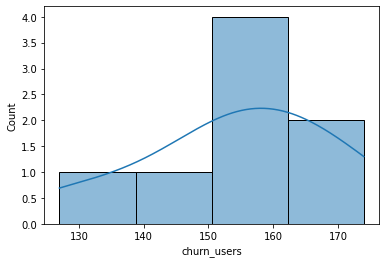

In [ ]:
sns.histplot(data=A_distr_churn_us, kde=True)

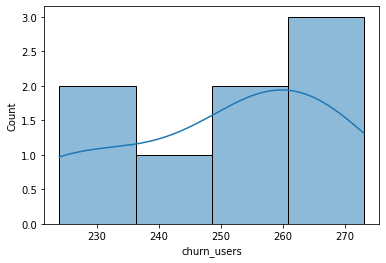

In [ ]:
sns.histplot(data=B_distr_churn_us, kde=True)

Видим, что значения в классах явно лежат в разных диапазонах, в классе В значительно больше пользователей, отказавшихся делать заказ, что уже говорит о значимости различий, однако проверим это с помощью уже известных критериев

## Проверка на нормальность

Используем критерий Шапиро, так как имеем мало значений в каждом классе. Критерий указывает на нормальность распределений, что, также было проверено и с помощью критерия Колмогорова <br>
Однако судя по гистограммам, распределения далеки от нормальных, что вызывает вопросы насчет правильности результатов критериев

In [ ]:
sh_a = shapiro(A_distr_churn_us)
sh_b = shapiro(B_distr_churn_us)

print('Распределение A {}нормальное\n'.format( {True:'не ',False:''}[sh_a[1] < alpha]))
print('Распределение B {}нормальное\n'.format( {True:'не ',False:''}[sh_b[1] < alpha]))

Распределение A нормальное

Распределение B нормальное



## Проверка равенства дисперсий

Критерий Шапиро показал, что оба распределения нормальные, что дает возможность применить Критерий Барлетта для проверки равенства дисперсий <br>
Однако опасаясь того, что нормальность все таки была определена неверно, проводим проверку равенства дисперсий еще и с помощью критерия Левена, и получаем тот же результат

In [ ]:
def bartlett_test(df1, df2, p_value = alpha): 
    st = bartlett(df1, df2) 
    print(st)
    print('Дисперсии распределений {}одинаковы\n'.format( {True:'не ', False:''}[st[1] < p_value]))

In [ ]:
bartlett_test(A_distr_churn_us, B_distr_churn_us)

BartlettResult(statistic=0.21722871910329028, pvalue=0.6411596569307136)
Дисперсии распределений одинаковы



In [ ]:
levene_test(A_distr_churn_us, B_distr_churn_us)

Дисперсии распределений равны

p-value: 0.6886192827142879, alpha: 0.05


## Оценка стат. значимости

Оценим стат. значимость различий исследуемых метрик в выборках с помощью двухвыборочного критерия Стьюдента,и видим, как и ожидали, что различия существенные <br>
Также покажем это на графиках 

In [ ]:
ttest = ttest_ind(A_distr_churn_us, B_distr_churn_us)
print('Различия {}существенны\n'.format( {False:'не ', True:''}[ttest[1] < alpha])) 
print('p-value: {}, alpha: {}'.format(ttest[1], alpha))

Различия существенны

p-value: 1.4341253748476907e-08, alpha: 0.05


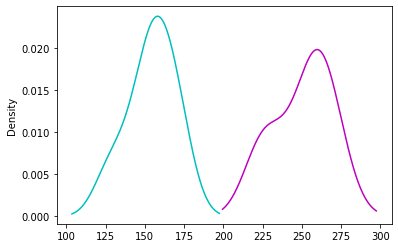

In [ ]:
A_distr_churn_us.plot.kde(color='c')
B_distr_churn_us.plot.kde(color='m')

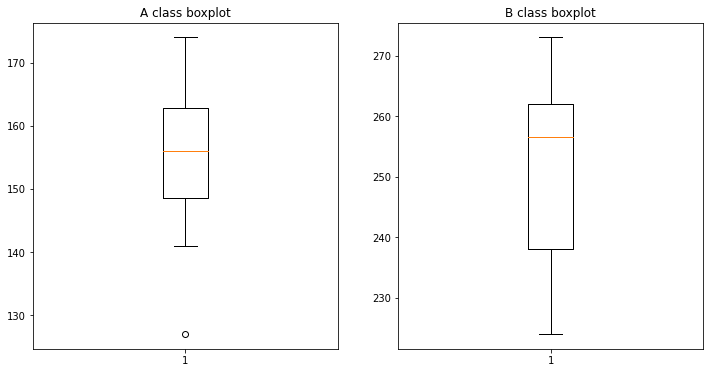

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.boxplot(A_distr_churn_us)
plt.title('A class boxplot')
plt.subplot(1, 2, 2)
plt.boxplot(B_distr_churn_us)
plt.title('B class boxplot')
plt.show()

## Подсчет объема выборок

Также посмотрим на необходимый объем выборок. Из-за большой разницы в диапазонах классов получим размер эффекта 5.34, что и является причиной такого небольшого количества необходимых записей - всего 2-3

In [ ]:
effect = (B_distr_churn_us.mean() - A_distr_churn_us.mean())/B_distr_churn_us.std() #5.34
alpha = 0.05
power = 0.8

analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Sample Size: %.3f' % result) 

Sample Size: 2.051


## Выводы

При исследовании двух метрик выяснилось, что нововведение повлекло значимое увеличение числа целевых действий, однако также и значительный прирост пользователей, отказавшихся сделать заказ. <br>
Это может объясниться тем, что некоторые пользователи не готовы к нововведениям, скорее всего сайт изменил какие-то значимые для них функции <br>

На этом этапе стоит проанализировать, что в перспективе принесет больший доход: нововведение, увеличивающее охваты, либо же старый проверенный метод, который устраивает большее количество пользователей. <br>
Важно посмотреть, что это за пользователи: заказывали ли они ранее, или попали на какую-то популярную рекламу и заказывают впервые